# TODO
- need all cells (ie non-MEL) to make argument for SC vs BULK analysis

# Setup

In [1]:
wkdir, s3dir = '/home/ubuntu/data/DL20190312_dish_mel', 'daniel.le-work/dish_MEL'
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_all']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var


scanpy version: 1.3.3


In [2]:
# FUNCTIONS
from collections import defaultdict
import multiprocessing

def single_mwu(args):    
    # inputs
    gene_val, df1, df2, alt = args
    
    try:
        stat, pval = stats.mannwhitneyu(df1[gene_val].values,
                                        df2[gene_val].values, 
                                        alternative = alt
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

def parallel_mwu(genes, df1, df2, method='two-sided', ncores=1):
    
    p = multiprocessing.Pool(processes=ncores)
    try:
        mwu_tuples = p.map(single_mwu, 
                                zip(genes,
                                    [df1]*len(genes),
                                    [df2]*len(genes),
                                    [method]*len(genes)
                                   ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()

    stat_list = [x[0] for x in mwu_tuples]
    pval_list = [x[1] for x in mwu_tuples]
    return (stat_list, pval_list)

def disp_analysis(adata, min_mean=0.0125, max_mean=10, min_disp=0.1):
    
    print('Process expression data...')
    print('\tInitial:')
    sum_output(adata)
    
    tmp = sc.pp.normalize_per_cell(adata, copy=True)
    filter_result = sc.pp.filter_genes_dispersion(tmp.X, 
                                                  min_mean=min_mean, 
                                                  max_mean=max_mean, 
                                                  min_disp=min_disp)
    tmp = tmp[:, filter_result.gene_subset]
    
    print('Filtered cells: {}'.format(len(adata.obs) - len(tmp.obs)))
    print('Filtered genes: {}'.format(len(adata.var_names) - len(tmp.var_names)))
    print('\tResult:')
    sum_output (tmp)
    
    return tmp

## Ingest data

In [3]:
run_me = False

if run_me == True:

    ### TRUNK ###

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D0_COI.h5ad'
    adata_d0 = ad.read_h5ad(filename)

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D6_COI.h5ad'
    adata_d6 = ad.read_h5ad(filename)

    # merge trunk
    adata_trunk = adata_d0.concatenate(adata_d6, join='outer')

    # update meta data with path and day
    adata_trunk.obs['path'] = 'trunk'
    adata_trunk.obs['path'] = adata_trunk.obs['path'].astype(str).astype(CategoricalDtype(['trunk']))
    adata_trunk.obs['day'] = [int(x.split('d')[-1]) for x in adata_trunk.obs['sample']]

    # prune genes by dispersion
    adata_trunk = disp_analysis(adata_trunk)

    ### DIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_all_COI.h5ad'
    adata_dir = ad.read_h5ad(filename)

    # replacement d15
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_D15v2_COI.h5ad'
    adata_d15v2_dir = ad.read_h5ad(filename)

    # remove old d15 and replace with new
    adata_dir = adata_dir[adata_dir.obs['sample'] != 'd15_dir']
    adata_dir = adata_dir.concatenate(adata_d15v2_dir, join='outer')

    # update meta data with path and day
    adata_dir.obs['path'] = 'direct'
    adata_dir.obs['path'] = adata_dir.obs['path'].astype(str).astype(CategoricalDtype(['direct']))
    adata_dir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_dir.obs['sample']]

    # add trunk
    adata_full_dir = adata_dir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
    adata_full_dir = disp_analysis(adata_full_dir)

    ### INDIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_indir_all_COI.h5ad'
    adata_indir = ad.read_h5ad(filename)

    # update meta data with path and day
    adata_indir.obs['path'] = 'indirect'
    adata_indir.obs['path'] = adata_indir.obs['path'].astype(str).astype(CategoricalDtype(['indirect']))
    adata_indir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_indir.obs['sample']]

    # add trunk
    adata_full_indir = adata_indir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
    adata_full_indir = disp_analysis(adata_full_indir)

    ### ALL ###

    # merge all
    adata_all = adata_trunk.concatenate(adata_dir, adata_indir, join='outer')

    # prune genes by dispersion
    adata_all = disp_analysis(adata_all)

    # update meta data with path and day
    adata_all.obs['path'] = adata_all.obs['path'].astype(str).astype(CategoricalDtype(['indirect','direct','trunk']))

    # freeze raw counts and scale
    # adata_all.X = sparse.csr_matrix(np.round(np.exp(adata_all.X.toarray())) - 1, dtype = np.float64)
    adata_all.raw = adata_all
    # sc.pp.log1p(adata_all)
    sc.pp.scale(adata_all)

    # UMAP and PCA
    input_adata = adata_all
    pca_adata(input_adata, num_pcs=25)
    umap_adata(input_adata, res=0.15, scan = False)

    # pickle adatas
    for objname in ['adata_all']:
        pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
        syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
        subprocess.run(syscmd.split(' '))


# PCA

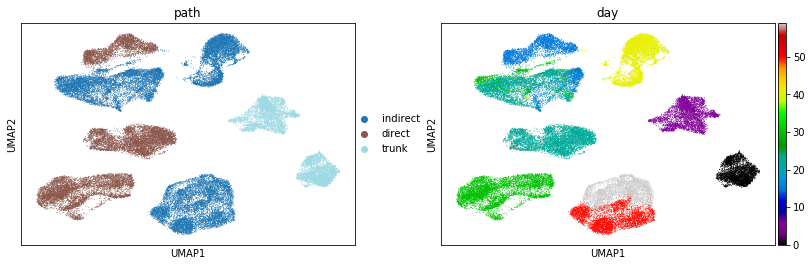

In [4]:
# sanity check
sc.pl.umap(adata_all, color = ['path', 'day'], palette = 'tab20', cmap = 'nipy_spectral')

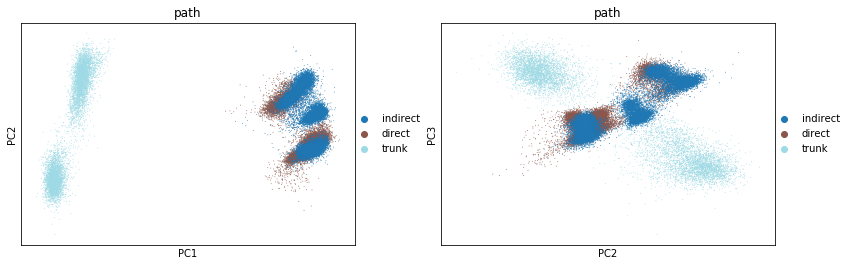

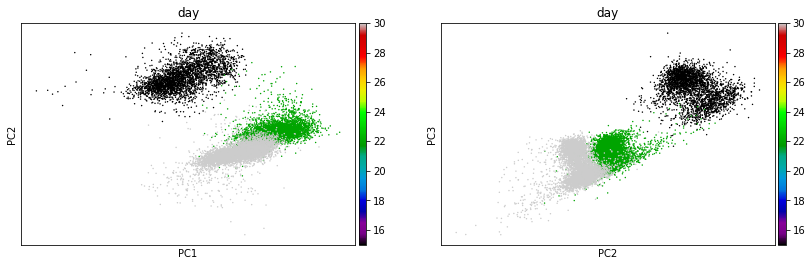

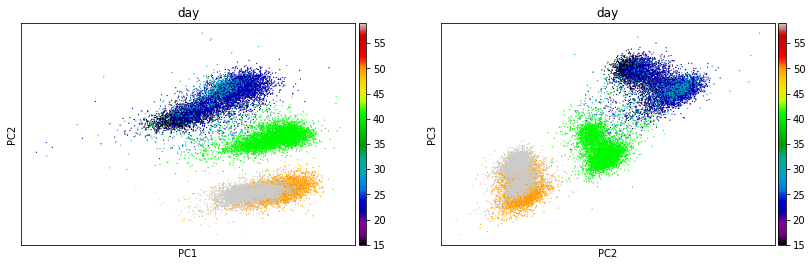

In [5]:
sc.pl.pca(adata_all, color = ['path'], components=['1,2','2,3'], palette = 'tab20')
sc.pl.pca(adata_all[adata_all.obs.path == 'direct'], color = ['day'], components=['1,2','2,3'], cmap = 'nipy_spectral')
sc.pl.pca(adata_all[adata_all.obs.path == 'indirect'], color = ['day'], components=['1,2','2,3'], cmap = 'nipy_spectral')



# Differential expression: path-specific terminally-differentiated

## Bulkized ranked correlation

In [6]:
# genes expressed exclusively in dir or indir
# dir d30 vs indir d50/59
## MWU tests
#

adata_dir_d30 = adata_all[[x == 30 and y == 'direct' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
adata_indir_d50_59 = adata_all[[x >= 50 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_dir_d30.var_names) & set(adata_indir_d50_59.var_names))

cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                         genes,
                                        'path',
                                         use_raw = True)

# bulkized correlation
print('bulkized spearman:', stats.spearmanr(adata_dir_d30_df.mean().values, adata_indir_d50_59_df.mean().values))


bulkized spearman: SpearmanrResult(correlation=0.9094070737686717, pvalue=0.0)


## Single-cell ranked location test

In [7]:

# mwu test: adt vs fet/neo
stat_pval_tuple = parallel_mwu(genes, 
                               adata_dir_d30_df.rank(pct=True, axis = 1, method = 'min'), 
                               adata_indir_d50_59_df.rank(pct=True, axis = 1, method = 'min'), 
                               'two-sided', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_pathspecific = (pd.DataFrame({'gene':genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )

print('sc mwu:')
display(mwu_pathspecific.dropna().sort_values('stat_1', ascending = False).head(10))

sc mwu:


,gene,stat_1,pval_1
2665,NMRK2,41736897.0,0.0
5566,CAPG,41144851.5,0.0
3559,STMN1,40756721.5,0.0
696,RAB38,40740912.5,0.0
5560,RPL7,40391776.0,0.0
2610,AKAP12,40352875.0,0.0
5593,SPP1,39993994.5,0.0
5091,IDH1,39971189.5,0.0
5095,ITM2B,39525235.0,0.0
5728,TAX1BP1,39286108.0,0.0


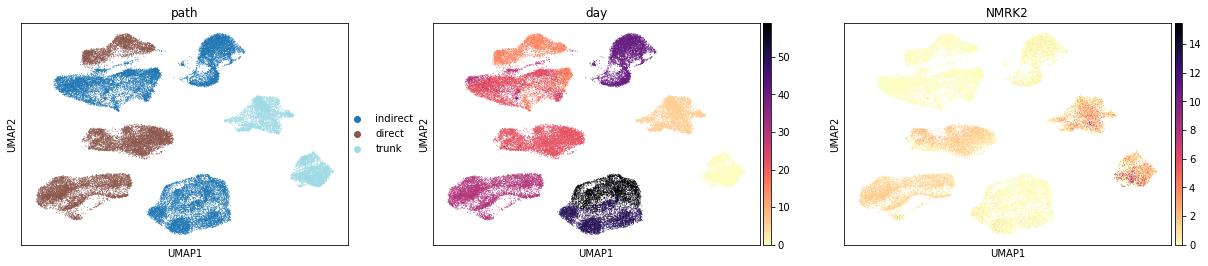

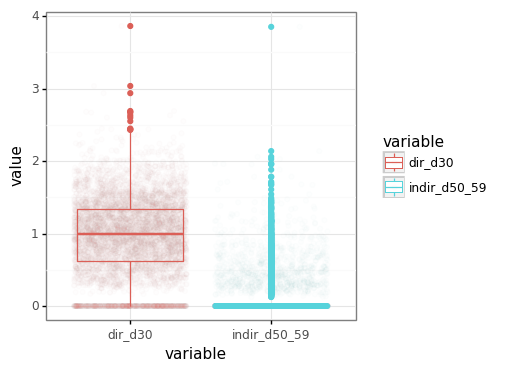

<ggplot: (-9223363248724968241)>
querying 1-1...done.
Finished.
0:  NMRK2 
 N/A


In [8]:
gene = 'NMRK2'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_dir_d30_df[gene].values,
                        'variable':'dir_d30'
                       }).append(pd.DataFrame({'value':adata_indir_d50_59_df[gene].values,
                                               'variable':'indir_d50_59'
                                              }))

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# Differential expression: d41 indirect

## Single-cell ranked location test

In [9]:
# determine DE unique indirect cluster

adata_indir_d41 = adata_all[[x == 41 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
# non-trunk rest
adata_rest = adata_all[[x != 41 and y in ['indirect','direct'] for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_indir_d41.var_names) & set(adata_rest.var_names))

cat, adata_indir_d41_df = prepare_dataframe(adata_indir_d41,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_rest_df = prepare_dataframe(adata_rest,
                                         genes,
                                        'path',
                                         use_raw = True)

# mwu test: indir_d41 vs rest
stat_pval_tuple = parallel_mwu(genes, 
                               adata_indir_d41_df.rank(pct=True, axis = 1, method = 'min'), 
                               adata_rest_df.rank(pct=True, axis = 1, method = 'min'), 
                               'greater', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df1 = (pd.DataFrame({'gene':genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )

display(mwu_df1.dropna().sort_values('stat_1', ascending = False).head(10))


,gene,stat_1,pval_1
4346,LRRC75A-AS1,133691479.0,0.0
3991,EIF3E,130431341.5,0.0
1645,C6orf48,129296993.5,0.0
967,ITM2C,128050554.0,0.0
5708,CAV1,126905611.5,0.0
1436,EIF3L,125787749.0,0.0
299,GAS5,125166679.5,0.0
484,EIF3F,124665158.0,0.0
1667,IFITM3,118706927.5,0.0
3201,S100A6,118699487.5,0.0


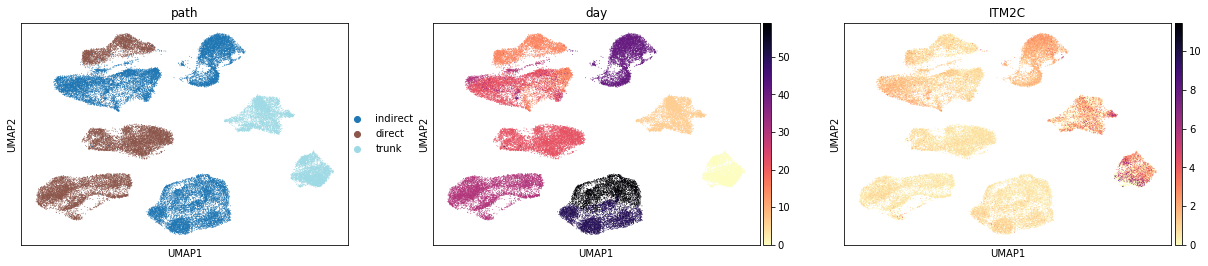

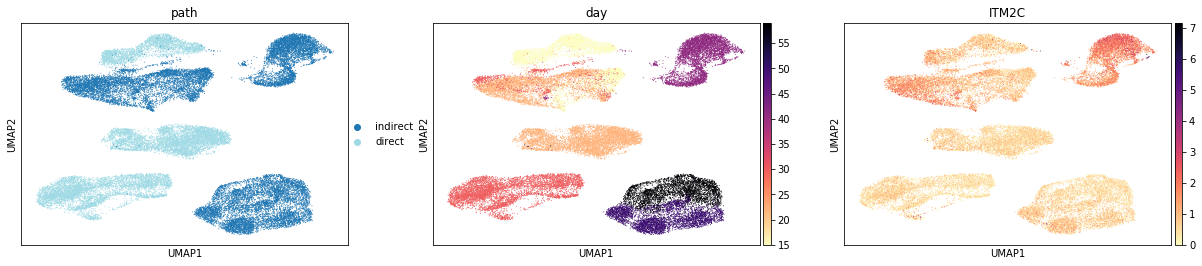

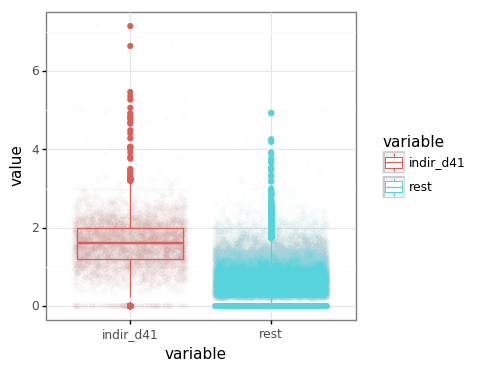

<ggplot: (-9223363248730872481)>
querying 1-1...done.
Finished.
0:  ITM2C 
 N/A


In [10]:
gene = 'ITM2C'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')
sc.pl.umap(adata_all[adata_all.obs.path != 'trunk'], color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_indir_d41_df[gene].values,
                        'variable':'indir_d41'
                       }).append(pd.DataFrame({'value':adata_rest_df[gene].values,
                                               'variable':'rest'
                                              }))

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# Comparison to primary fetal melanocytes

## Bulkized ranked correlation

In [11]:
## read in adata with fetal melanocytes = adata_subset2
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
for file in ['adata_subset2']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

adata_subset2.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset2.obs.age]
adata_subset2.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset2.obs.general_location]
adata_subset2.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(adata_subset2.obs.dev_stage, adata_subset2.obs.subtypes)]


In [12]:
# bulk-ize terminal direct and indirect...spearman correlation to bulkized fetal
genes = list(set(adata_subset2.var_names) & set(adata_all.var_names))
input_adata = adata_subset2

for i in list(set(adata_subset2.obs.dev_subtype)):
    print(i)
    input_adata = adata_subset2[adata_subset2.obs.dev_subtype == i]

    cat, adata_subset2_df = prepare_dataframe(input_adata,
                                             genes,
                                            'patient',
                                             use_raw = True)
    adata_subset2_vec = adata_subset2_df.mean().values

    cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                             genes,
                                            'path',
                                             use_raw = True)
    adata_dir_d30_vec = adata_dir_d30_df.mean().values
    stat, pval = stats.spearmanr(adata_subset2_vec, adata_dir_d30_vec)
    print('direct', stat, pval)

    cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                             genes,
                                            'path',
                                             use_raw = True)
    adata_indir_d50_59_vec = adata_indir_d50_59_df.mean().values
    stat, pval = stats.spearmanr(adata_subset2_vec, adata_indir_d50_59_vec)
    print('indirect', stat, pval, '\n')


fet_acral
direct 0.7027344352644193 0.0
indirect 0.7209836383966651 0.0 

fet_cutaneous
direct 0.707975708363957 0.0
indirect 0.7248994894821417 0.0 

adt_acral
direct 0.6250045966653603 1.9464478978622888e-264
indirect 0.6327873010618701 5.174704986286764e-273 

neo_foreskin
direct 0.705877087421566 0.0
indirect 0.7134769949801489 0.0 

adt_cutaneous
direct 0.6385277179826385 1.6957600082584674e-279
indirect 0.6522236330636108 1.530492007258205e-295 



##  Single cell ranked location test

In [13]:
fetal_adata = adata_subset2[adata_subset2.obs.dev_stage == 'fet']
genes = list(set(fetal_adata.var_names) & set(mwu_pathspecific.gene))
cat, fetal_slice = prepare_dataframe(fetal_adata,
                                     var_names = genes,
                                     groupby = 'patient')

alpha = 0.05
adj_alpha = alpha / (len(genes) * 2)

path_specific_df = pd.DataFrame()
for path in ['direct', 'indirect']:
    if path == 'direct':
        slice_df = adata_dir_d30
    elif path == 'indirect':
        slice_df = adata_indir_d50_59
    cat, prep_slice = prepare_dataframe(slice_df,
                                     var_names = genes,
                                     groupby = 'path')

    stat_pval_tuple = parallel_mwu(genes, 
                               fetal_slice.rank(pct=True, axis = 1, method = 'min'), 
                               prep_slice.rank(pct=True, axis = 1, method = 'min'), 
                               'two-sided',
                               7)
    stat_list = stat_pval_tuple[0]
    pval_list = stat_pval_tuple[1]
    tmp_df = (pd.DataFrame({'gene':genes,
                             'stat_2':stat_list,
                             'pval_2':pval_list
                            })
              )
    tmp_df['path'] = path
    tmp_df['pass'] = [x < adj_alpha for x in tmp_df['pval_2']]
    path_specific_df = path_specific_df.append(tmp_df)
    
path_specific_df = pd.merge(mwu_pathspecific, path_specific_df, 'left', 'gene')
path_specific_df = path_specific_df.dropna().sort_values('stat_1', ascending = False)
keep_genes = path_specific_df.groupby('gene')['pass'].sum()
keep_genes = keep_genes[keep_genes == 1].index.tolist()
path_specific_df = path_specific_df[[x in keep_genes for x in path_specific_df.gene]]
display(path_specific_df.head(10))


,gene,stat_1,pval_1,stat_2,pval_2,path,pass
7871,CAPG,41144851.5,0.0,8159798.0,2.809388e-05,indirect,False
7870,CAPG,41144851.5,0.0,1507798.0,0.000000e+00,direct,True
3849,MPPED2,33259044.0,0.0,3019296.0,6.566075e-310,direct,True
3850,MPPED2,33259044.0,0.0,7756880.0,5.235585e-02,indirect,False
2276,COL4A3BP,32020967.0,0.0,5560999.0,5.965420e-04,direct,False
2277,COL4A3BP,32020967.0,0.0,10487380.5,5.610511e-156,indirect,True
2330,PPARGC1A,31886837.0,0.0,7764987.0,3.905250e-02,indirect,False
2329,PPARGC1A,31886837.0,0.0,3382926.0,1.889887e-258,direct,True
8256,NGF,31722647.0,0.0,7713673.5,4.662369e-05,indirect,False
8255,NGF,31722647.0,0.0,3393180.5,7.196921e-257,direct,True


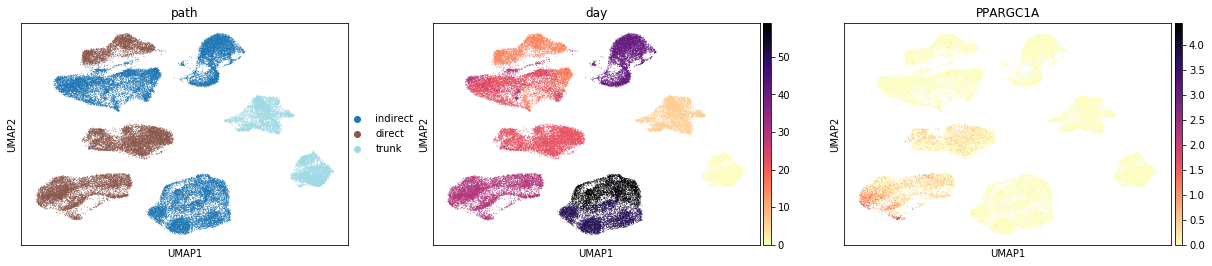

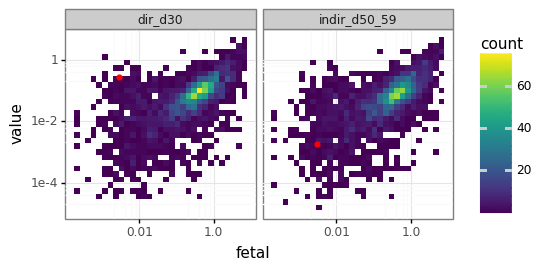

<ggplot: (8788129821809)>


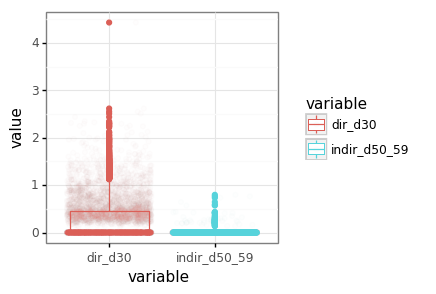

<ggplot: (-9223363248775974084)>
querying 1-1...done.
Finished.
0:  PPARGC1A 
 The protein encoded by this gene is a transcriptional coactivator that regulates the genes involved in energy metabolism. This protein interacts with PPARgamma, which permits the interaction of this protein with multiple transcription factors. This protein can interact with, and regulate the activities of, cAMP response element binding protein (CREB) and nuclear respiratory factors (NRFs). It provides a direct link between external physiological stimuli and the regulation of mitochondrial biogenesis, and is a major factor that regulates muscle fiber type determination. This protein may be also involved in controlling blood pressure, regulating cellular cholesterol homoeostasis, and the development of obesity. [provided by RefSeq, Jul 2008].


In [14]:
# gene lookup

gene = 'PPARGC1A'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_dir_d30_df[gene].values,
                        'variable':'dir_d30'
                       }).append(pd.DataFrame({'value':adata_indir_d50_59_df[gene].values,
                                               'variable':'indir_d50_59'
                                              }))

point_df = pd.DataFrame(plot_df.groupby('variable').mean())
point_df['fetal'] = fetal_slice.loc[:,gene].mean()
point_df = point_df.reset_index()

bulkize_df = pd.DataFrame({'fetal':adata_subset2_vec, 
                          'dir_d30':adata_dir_d30_vec,
                          'indir_d50_59':adata_indir_d50_59_vec})
bulkize_df = pd.melt(bulkize_df, id_vars='fetal')

plotnine.options.figure_size = (5,5)
print(ggplot()
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_bin2d(bulkize_df, aes('fetal','value'))
      + geom_point(point_df, aes('fetal', 'value'), color = 'red')
      + facet_wrap('~variable')
      + scale_x_log10()
      + scale_y_log10()
     )

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# DEV: velocyto

In [15]:
import loompy
import os
import scvelo as scv

In [16]:
run = False

filedir = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/'
files = [''.join([filedir,x]) for x in os.listdir(filedir) if (x.endswith('.loom') and x != 'merged.loom')]
for x in files:
    print(x)

filename = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/merged.loom'
if run == True:
    loompy.combine(files,filename,"Accession")


/home/ubuntu/data/DL20190312_dish_mel/velocyto/d15_dir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d6_trunk.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d15_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d22_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d0_trunk.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d41_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d22_dir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d59_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d30_dir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d50_indir.loom
/home/ubuntu/data/DL20190312_dish_mel/velocyto/d30_indir.loom


In [17]:
adata = scv.read(filename, cache=True)
adata_velo_merge = scv.utils.merge(adata_all, adata)

scv.pp.filter_and_normalize(adata_velo_merge)
scv.pp.moments(adata_velo_merge)
scv.tl.velocity(adata_velo_merge)
scv.tl.velocity_graph(adata_velo_merge)
scv.tl.velocity_embedding(adata_velo_merge, basis='pca')


... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:25.11) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:26.95) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:06.94) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:01:27.86) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:14.28) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

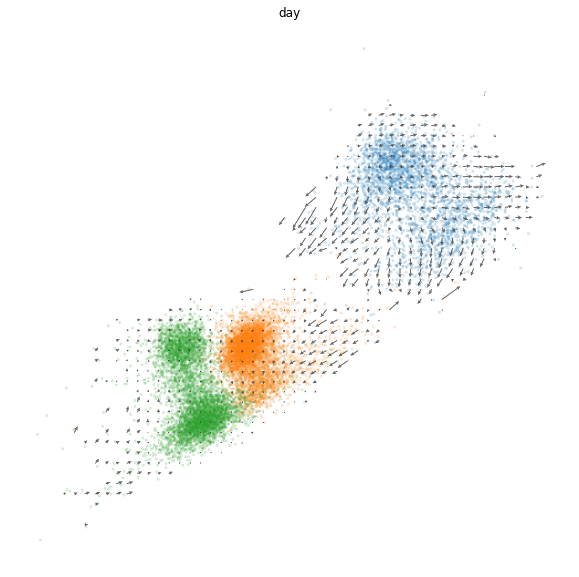

<Figure size 432x288 with 0 Axes>

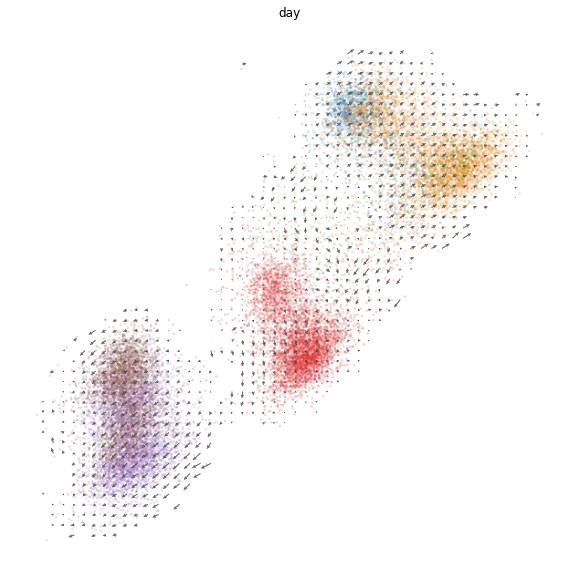

In [18]:
component = '2,3'
scv.pl.velocity_embedding_grid(adata_velo_merge[adata_velo_merge.obs.path == 'direct'], 
                               basis='pca', 
                               figsize = (10,10),
                               components = component,
                               color = ['day']
                              )

scv.pl.velocity_embedding_grid(adata_velo_merge[adata_velo_merge.obs.path == 'indirect'], 
                               basis='pca', 
                               figsize = (10,10),
                               components = component,
                               color = ['day']
                              )
